# Pixel classification on OpenCL-compatible GPUs
Alternatively to object or "instance" segmentation, we can also do semantic segmentation by classifying pixels.

Let's start with loading an example image and some ground truth:

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import apoc
import pyclesperanto_prototype as cle
import stackview

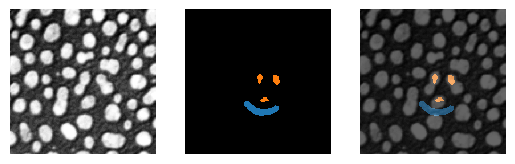

In [2]:
image = imread('data/blobs.tif')

manual_annotation = imread('data/blobs_annotations.tif')

fig, axs = plt.subplots(1,3)

stackview.imshow(image, plot=axs[0])
stackview.imshow(manual_annotation, labels=True, plot=axs[1])
stackview.imshow(image, plot=axs[2], continue_drawing=True)
stackview.imshow(manual_annotation, labels=True, plot=axs[2], alpha=0.6)

## Training: semantic segmentation
We now train a PixelClassifier, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [3]:
# define features: original image, a blurred version and an edge image
features = "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'data/pixel_classifier.cl'

apoc.erase_classifier(cl_filename)
pixel_classifier = apoc.PixelClassifier(opencl_filename=cl_filename)
pixel_classifier.train(features, manual_annotation, image)

pixel_classifier

Classifier type: PixelClassifier
--- Random forest info ---
Used features for training: original gaussian_blur=2 sobel_of_gaussian_blur=2
Ground truth dimensions: 2
Maximum depth: 2
Number of ensembles: 100
Number of classes: 2
Number of features: 3
Number of channels: 1

## Prediction
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. 

StackViewNDArray([[1, 1, 1, ..., 2, 2, 2],
                  [1, 1, 1, ..., 2, 2, 2],
                  [1, 1, 1, ..., 2, 2, 2],
                  ...,
                  [1, 1, 1, ..., 1, 1, 1],
                  [1, 1, 1, ..., 1, 1, 1],
                  [1, 1, 1, ..., 1, 1, 1]], dtype=uint32)
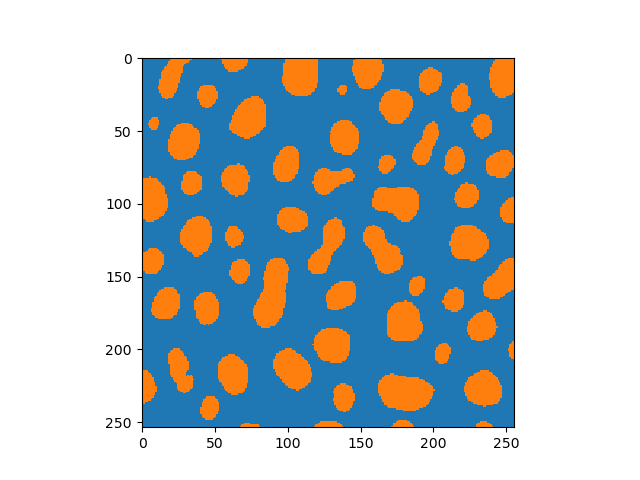

In [4]:
result = pixel_classifier.predict(image=image)

stackview.insight(result)

## Training: Instance segmentation
If goal is analysis of individual objects, we can train an ObjectSegmenter which has a similar API like the PixelClassifier:

In [5]:
# define features
features =  "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'data/blobs_object_segmenter.cl'

apoc.erase_classifier(cl_filename)
object_segmenter = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
object_segmenter.train(features, manual_annotation, image)

object_segmenter

Classifier type: ObjectSegmenter
--- Random forest info ---
Used features for training: original gaussian_blur=2 sobel_of_gaussian_blur=2
Ground truth dimensions: 2
Maximum depth: 2
Number of ensembles: 100
Number of classes: 2
Number of features: 3
Number of channels: 1Positive class identifier: 2

StackViewNDArray([[ 0,  0,  0, ..., 58, 58, 58],
                  [ 0,  0,  0, ..., 58, 58, 58],
                  [ 0,  0,  0, ..., 58, 58, 58],
                  ...,
                  [ 0,  0,  0, ...,  0,  0,  0],
                  [ 0,  0,  0, ...,  0,  0,  0],
                  [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
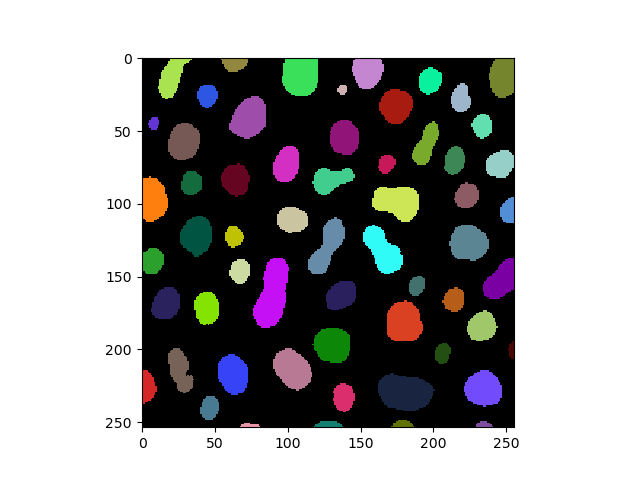

In [6]:
segmentation_result = object_segmenter.predict(image=image)

stackview.insight(segmentation_result)

## Exercise
Modify the annotation so that not the objects are segmented, but the border of the objects.